## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
# nltk.download('gutenberg')
import tensorflow as tf
import pickle
from nltk.corpus import gutenberg
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

## Loading Dataset

In [2]:
data = gutenberg.raw('shakespeare-hamlet.txt')

In [3]:
with open(file='hamlet.txt', mode='w') as file:
    file.write(data)

## Data Preprocessing

In [4]:
with open(file='hamlet.txt', mode='r') as file:
    text = file.read().lower()

tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
total_words = len(tokenizer.word_index) + 1
total_words

4818

## Create Input Sequence

In [5]:
input_sequences = []

for line in text.split('\n'):
    token_list = tokenizer.texts_to_sequences([line])[0]
    for token in range(1, len(token_list)):
        n_gram_sequence = token_list[:token+1]
        input_sequences.append(n_gram_sequence)

input_sequences

[[1, 687],
 [1, 687, 4],
 [1, 687, 4, 45],
 [1, 687, 4, 45, 41],
 [1, 687, 4, 45, 41, 1886],
 [1, 687, 4, 45, 41, 1886, 1887],
 [1, 687, 4, 45, 41, 1886, 1887, 1888],
 [1180, 1889],
 [1180, 1889, 1890],
 [1180, 1889, 1890, 1891],
 [57, 407],
 [57, 407, 2],
 [57, 407, 2, 1181],
 [57, 407, 2, 1181, 177],
 [57, 407, 2, 1181, 177, 1892],
 [407, 1182],
 [407, 1182, 63],
 [408, 162],
 [408, 162, 377],
 [408, 162, 377, 21],
 [408, 162, 377, 21, 247],
 [408, 162, 377, 21, 247, 882],
 [18, 66],
 [451, 224],
 [451, 224, 248],
 [451, 224, 248, 1],
 [451, 224, 248, 1, 30],
 [408, 407],
 [451, 25],
 [408, 6],
 [408, 6, 43],
 [408, 6, 43, 62],
 [408, 6, 43, 62, 1893],
 [408, 6, 43, 62, 1893, 96],
 [408, 6, 43, 62, 1893, 96, 18],
 [408, 6, 43, 62, 1893, 96, 18, 566],
 [451, 71],
 [451, 71, 51],
 [451, 71, 51, 1894],
 [451, 71, 51, 1894, 567],
 [451, 71, 51, 1894, 567, 378],
 [451, 71, 51, 1894, 567, 378, 80],
 [451, 71, 51, 1894, 567, 378, 80, 3],
 [451, 71, 51, 1894, 567, 378, 80, 3, 273],
 [451, 71

## Pad Sequence

In [6]:
max_sequence_length = max([len(sequence) for sequence in input_sequences])
max_sequence_length

14

In [7]:
input_sequences = np.array(
    pad_sequences(
        sequences=input_sequences,
        maxlen=max_sequence_length,
        padding='pre',
    )
)

input_sequences

array([[   0,    0,    0, ...,    0,    1,  687],
       [   0,    0,    0, ...,    1,  687,    4],
       [   0,    0,    0, ...,  687,    4,   45],
       ...,
       [   0,    0,    0, ...,    4,   45, 1047],
       [   0,    0,    0, ...,   45, 1047,    4],
       [   0,    0,    0, ..., 1047,    4,  193]], dtype=int32)

## Create Predictors and Labels

In [8]:
X, y = input_sequences[:, :-1], input_sequences[:, -1]

In [9]:
X

array([[   0,    0,    0, ...,    0,    0,    1],
       [   0,    0,    0, ...,    0,    1,  687],
       [   0,    0,    0, ...,    1,  687,    4],
       ...,
       [   0,    0,    0, ...,  687,    4,   45],
       [   0,    0,    0, ...,    4,   45, 1047],
       [   0,    0,    0, ...,   45, 1047,    4]], dtype=int32)

In [10]:
y

array([ 687,    4,   45, ..., 1047,    4,  193], dtype=int32)

### Converting Labels into Categories

In [11]:
y = tf.keras.utils.to_categorical(y, num_classes=total_words)
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Train Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
)

## Creating the Model

In [13]:
optimizer = optimizers.Adam(learning_rate=0.001)
loss = losses.CategoricalCrossentropy()
metrics=['accuracy']

In [14]:
model = Sequential()

model.add(Embedding(input_dim=total_words, output_dim=100, input_shape=(max_sequence_length-1,)))
model.add(GRU(units=150, return_sequences=True, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(GRU(units=100, activation='relu'))
model.add(Dense(units=total_words, activation='softmax'))

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 13, 100)        │       481,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 13, 150)        │       113,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100)            │        75,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4818)           │       486,618 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,157,418 (4.42 MB)

 Trainable params: 1,157,418 (4.42 MB)

 Non-trainable params: 0 (0.00 B)

## Training the Model

In [16]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [17]:
model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_test, y_test),
    # callbacks=[early_stopping],
)

Epoch 1/50
644/644 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.0279 - loss: 7.1148 - val_accuracy: 0.0338 - val_loss: 6.6824
Epoch 2/50
644/644 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.0356 - loss: 6.4052 - val_accuracy: 0.0408 - val_loss: 6.7879
Epoch 3/50
644/644 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.0464 - loss: 6.2005 - val_accuracy: 0.0573 - val_loss: 6.8943
Epoch 4/50
644/644 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.0650 - loss: 5.9150 - val_accuracy: 0.0626 - val_loss: 7.0275
Epoch 5/50
644/644 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.0710 - loss: 5.7060 - val_accuracy: 0.0754 - val_loss: 7.2354
Epoch 6/50
644/644 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.0872 - loss: 5.4658 - val_accuracy: 0.0762 - val_loss: 7.3278
Epoch 7/50
644/644 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.0970 - loss: 5.2517 - val_accuracy: 0.0756 - val_loss: 7.7354
Epoch 8/50
644/644 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.1100 - loss: 5.0192 - val_accuracy: 0.

In [18]:
train_df = pd.DataFrame(
    {
        'accuracy': model.history.history['accuracy'], 
        'loss': model.history.history['loss']
    }
)

validation_df = pd.DataFrame(
    {
        'val_accuracy': model.history.history['val_accuracy'], 
        'val_loss': model.history.history['val_loss']
    }
)

In [19]:
train_df.head()

,accuracy,loss
0,0.031722,6.850913
1,0.037600,6.431656
2,0.050619,6.205300
3,0.063930,5.945217
4,0.073792,5.710595


In [20]:
validation_df.head()

,val_accuracy,val_loss
0,0.033806,6.682405
1,0.040800,6.787881
2,0.057315,6.894323
3,0.062561,7.027501
4,0.075384,7.235396


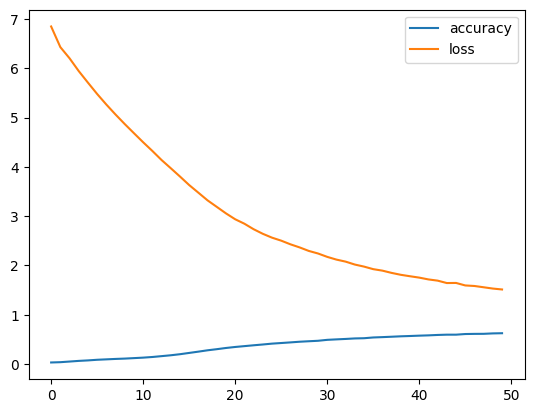

In [21]:
train_df.plot();

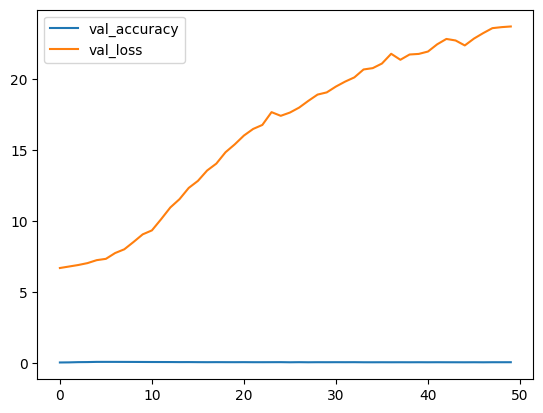

In [22]:
validation_df.plot();

## Saving the Model

In [23]:
model.save('next_word_prediction_gru.keras')

## Saving Tokenizer

In [24]:
with open(file='tokenizer.pickle', mode='wb') as file:
    pickle.dump(
        obj=tokenizer,
        file=file,
        protocol=pickle.HIGHEST_PROTOCOL
    )

## Predicting Next Word

In [25]:
def predict_next_word(model, tokenizer, text, max_sequence_length):
    token_list = tokenizer.texts_to_sequences([text])[0]
    if len(token_list) >= max_sequence_length:
        token_list = token_list[-(max_sequence_length-1):]

    token_list = pad_sequences(
        sequences=[token_list],
        maxlen=max_sequence_length-1,
        padding='pre',
    )

    predicted = model.predict(token_list, verbose=0)
    predicted_word_index = np.argmax(predicted, axis=1)

    for word, index in tokenizer.word_index.items():
        if index == predicted_word_index:
            return word
    return None

In [26]:
input_text = "To be or not to be"
max_sequence_length = model.input_shape[1]+1

In [27]:
next_word = predict_next_word(
    model=model,
    tokenizer=tokenizer,
    text=input_text,
    max_sequence_length=max_sequence_length
)

In [28]:
print(f"Input Text: {input_text}")
print(f"Next Word Prediction: {next_word}")

Input Text: To be or not to be
Next Word Prediction: our


In [29]:
input_text = "Barn. In the same figure, like the"
max_sequence_length = model.input_shape[1]+1

next_word = predict_next_word(
    model=model,
    tokenizer=tokenizer,
    text=input_text,
    max_sequence_length=max_sequence_length
)

print(f"Input Text: {input_text}")
print(f"Next Word Prediction: {next_word}")

Input Text: Barn. In the same figure, like the
Next Word Prediction: other


In [30]:
input_text = " Mar. Good now sit downe, &"
max_sequence_length = model.input_shape[1]+1

next_word = predict_next_word(
    model=model,
    tokenizer=tokenizer,
    text=input_text,
    max_sequence_length=max_sequence_length
)

print(f"Input Text: {input_text}")
print(f"Next Word Prediction: {next_word}")

Input Text:  Mar. Good now sit downe, &
Next Word Prediction: tell
